### 0) Setup

In [1]:
import os, sys, json, numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42
pd.set_option("display.max_columns", 100)

### 1) Load data

In [4]:
# Replace with local path or URL; Titanic example if used
df = pd.read_csv("Titanic-Dataset.csv")  # or any dataset relevant to the task
print(df.shape)
print()
print(df.dtypes)
print()
print(df.isna().sum().sort_values(ascending=False))

(891, 12)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64


### 2) Split features/target if applicable (use a dummy target if purely preprocessing)

In [5]:
target_col = None  # e.g., "Survived" for Titanic
if target_col and target_col in df.columns:
    y = df[target_col]
    X = df.drop(columns=[target_col])
else:
    X = df.copy()
    y = None

### 3) Identify column types

In [6]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print({"num_cols": num_cols, "cat_cols": cat_cols})

{'num_cols': ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], 'cat_cols': ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']}


### 4) Preprocessing blocks

In [7]:
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),  # mean/median as per guide
    ("scaler", StandardScaler())                    # standardization option
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ],
    remainder="drop"
)

### 5) Fit-transform

In [8]:
Xt = pre.fit_transform(X)
# Reconstruct processed DataFrame with feature names
num_features = num_cols
cat_features = list(pre.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_cols)) if cat_cols else []
proc_cols = num_features + cat_features
X_proc = pd.DataFrame(Xt, columns=proc_cols)
print(X_proc.head())

   PassengerId  Survived    Pclass       Age     SibSp     Parch      Fare  \
0    -1.730108 -0.789272  0.827377 -0.592481  0.432793 -0.473674 -0.502445   
1    -1.726220  1.266990 -1.566107  0.638789  0.432793 -0.473674  0.786845   
2    -1.722332  1.266990  0.827377 -0.284663 -0.474545 -0.473674 -0.488854   
3    -1.718444  1.266990 -1.566107  0.407926  0.432793 -0.473674  0.420730   
4    -1.714556 -0.789272  0.827377  0.407926 -0.474545 -0.473674 -0.486337   

   Name_Abbing, Mr. Anthony  Name_Abbott, Mr. Rossmore Edward  \
0                       0.0                               0.0   
1                       0.0                               0.0   
2                       0.0                               0.0   
3                       0.0                               0.0   
4                       0.0                               0.0   

   Name_Abbott, Mrs. Stanton (Rosa Hunt)  Name_Abelson, Mr. Samuel  \
0                                    0.0                       0.0   


### 6) Outlier visualization (pre- or post-scale as needed)

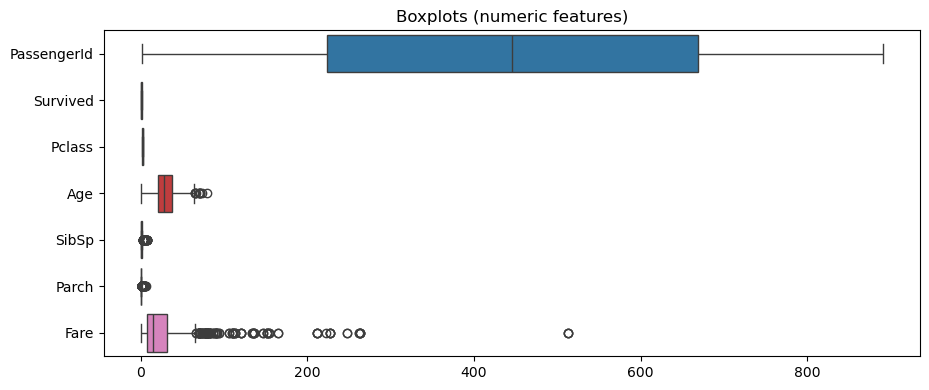

In [9]:
plt.figure(figsize=(min(12, 1+len(num_cols)*1.2), 4))
sns.boxplot(data=X[num_cols], orient="h")
plt.title("Boxplots (numeric features)")
plt.tight_layout()
plt.savefig("boxplots_numeric.png", dpi=150)

### 7) Winsorize or IQR-based trimming

In [10]:
def iqr_filter(df_num, k=1.5):
    mask = pd.Series(True, index=df_num.index)
    for c in df_num.columns:
        q1, q3 = df_num[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - k*iqr, q3 + k*iqr
        mask &= df_num[c].between(lower, upper) | df_num[c].isna()
    return mask

mask = iqr_filter(X[num_cols])
X_trim = X.loc[mask].reset_index(drop=True)
if y is not None:
    y_trim = y.loc[mask].reset_index(drop=True)

# Refit preprocessing on trimmed data if removing outliers
Xt2 = pre.fit_transform(X_trim)
num_features = num_cols
cat_features = list(pre.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_cols)) if cat_cols else []
X_proc2 = pd.DataFrame(Xt2, columns=num_features + cat_features)
X_proc2.to_csv("X_processed.csv", index=False)
if y is not None:
    y_trim.to_csv("y_processed.csv", index=False)